In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import codecs
import os
import pandas as pd
import numpy as np
import string
import random
import pickle
from tqdm import tqdm

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist

from gensim.models import Word2Vec

from tensorflow.keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import multiprocessing as mp

from sklearn.model_selection import train_test_split # Modelado
from sklearn.pipeline import Pipeline # Modelado
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # Modelado
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression # Reporte
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve

path = '/content/drive/MyDrive/NLP_practica/datasets/' #path en donde esta almacenado el df

###Vamos a generar una función que nos sube al archivo de este notebook, el colab que tiene almacenada la clase Grapihcs para poder usarla en este documento

In [ ]:
def uploudFile(file_name: str, file_path: str, destination_path: str) ->None:
  try:
    # Leemos el contenido del archivo como una cadena de texto
    with codecs.open(f'{file_path}{file_name}', 'r', encoding='utf-8') as f:
        file_content = f.read()
    # Escribe el contenido del archivo en un nuevo archivo con la misma ruta
    with codecs.open(destination_path, 'w', encoding='utf-8') as f:
        f.write(file_content)
    print('[INFO]Archivo cargado correctamente')
  except FileNotFoundError:
    print('[ERROR]No se ha podido realizar la carga del archivo')  

In [ ]:
# Define la ruta del archivo en tu Google Drive, la ruta de destino y el nombre del archivo
file_path = '/content/drive/MyDrive/NLP_practica/'  
file_name = 'graphics_nlp.py'
destination_path = '/content/graphics_nlp.py'
# Lee el contenido del archivo como una cadena de texto

uploudFile(file_name= file_name, file_path= file_path,destination_path= destination_path)

[INFO]Archivo cargado correctamente


In [ ]:
#Importamos el libreria creada para visualizar graficas
from graphics_nlp import Graphics

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

##Generamos una clase llamada Preprocessing que realiza el preprocesado de forma automatica

In [7]:
class Preprocessing():
  """pipeline de preprocesado que consta de: EliminacionNulos -> Normalización -> Lemmatización -> EliminarStopWord"""
  def __init__(self,  df:pd.DataFrame, stop_words: set) -> None:
    """constructor que genera las variables de clase necesarias
      : param df: pd.DataFrame  set de datos a tratar
      : param stop_words: set con las palabras a eliminar
      return None"""
    self.df = self.deleteNan(df).copy() #Eliminamos las reviews con cero palabras
    self.stop_words = stop_words
    self.processed_token = []
    self.lemmatizer = WordNetLemmatizer()
    
  def run(self) -> pd.DataFrame:
    """método que ejecuta todo el pipeline de preprocesado llamando a los diferentes metodos que se encargan del proceso
      return: pd.DataFrame  devuelve el df transformado"""
    print('[INFO] Realizando el preprocesado...')
    for token in tqdm(self.df['tokens']):
      
      # Normalizamos los tokens      
      normalized_tokens = self.token_normalization(token)
      
      # Lematizamos los tokens      
      lemmatized_tokens = [self.lemmatize(word, self.lemmatizer)for word in normalized_tokens]
      
      # Eliminamos las stop words
      filtered_tokens = self.remove_stopwords(lemmatized_tokens, self.stop_words)
      
      # Agregamos los tokens procesados a la lista
      self.processed_token.append(filtered_tokens)  
    
    self.df.loc[:, 'processed_tokens'] = self.processed_token

    #añadimos los POS tags
    self.processed_tags = self.posTag(self.df['processed_tokens'])
    self.df.loc[:, 'processed_task'] = self.processed_tags
    print('\n[INFO] Preprocesado realizado con éxito.')
    return self.df


  @staticmethod
  def token_normalization(token:str) -> str: 
    """método que realiza la elimnacion de signos de puntuación y caracteres especiales
     : param token: sentencias"""   
    # Eliminar los signos de puntuación y caracteres especiales de cada palabra
    token = token.translate(str.maketrans('', '', string.punctuation))
    # Convertir a minúsculas
    token = token.lower() 
    return token.split()

  @staticmethod
  def lemmatize(token: str, lemmatizer:WordNetLemmatizer) ->list: 
    """metodo que realiza la lematizacion 
      : param token: str- frase a lematizar
      : param lemmatizer:  objeto de la clase WordNetLemmatizer
      return list texto lematizado"""  
    # Lematizar el token utilizando WordNetLemmatizer    
    return lemmatizer.lemmatize(token)

  @staticmethod
  def remove_stopwords(tokens: str, stop_words: set) -> list:
    """metodo que realiza la eliminación de stopwords 
      : param token: str- frase a tratar
      : param stop_words:  set con las palabras a eliminar
      return : list con las stopword eliminadas""" 
    tokens = tokens
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return filtered_tokens

  @staticmethod
  def posTag(tokens: pd.Series) -> list:
    """método que genera los pos a las palabras
    :param tokens: pd.series con la columna de los tokens procesados
    return: texto con tagas"""
    print('[INFO]Generando los pos_tags...')
    pos_tagged = [nltk.pos_tag(token) for token in tqdm(tokens)]
    pos_tagged_text= []
    print('[INFO]Procesando los pos_tags...')
    for i in tqdm(range(len(pos_tagged))):
      pos_tagged_text.append(" ".join([token[0] + "_" + token[1] for token in pos_tagged[i]]))
    return pos_tagged_text

  @staticmethod
  def deleteNan(df: pd.DataFrame) -> pd.DataFrame:
    #Eliminamos los documentos que no tienen review
    mask = df['text_length'] != 0 #mascara boleana 
    return df.loc[mask]

  

Cargamos el csv que contiene el df obtenido en el notebook dowloadExplorationData.ipynb

In [8]:
df = pd.read_csv(f'{path}/df_balanced.csv')

###Vamos a realizar el preprocesado de los datos con la ayuda de la clase Preprocesing

In [9]:
#almacenamos en una variable las stop words
stop_words = set(stopwords.words('english'))
#creamos la instancia de la clase Preprocessing
preprocesing = Preprocessing(df= df, stop_words=stop_words)
#llamamos al metodo run para que ejecute el preprocesado
processed_df = preprocesing.run()

[INFO] Realizando el preprocesado...


100%|██████████| 4997/4997 [00:04<00:00, 1064.48it/s]


[INFO]Generando los pos_tags...


100%|██████████| 4997/4997 [00:19<00:00, 260.82it/s]


[INFO]Procesando los pos_tags...


100%|██████████| 4997/4997 [00:00<00:00, 76986.42it/s]


[INFO] Preprocesado realizado con éxito.


In [ ]:
processed_df.head()


,review,sentiment,sentiment_label,tokens,text_length,processed_tokens,processed_task
0,"I bought these headphones, hoping that they wi...",2.0,1,"['i', 'bought', 'these', 'headphones', ',', 'h...",112,"[bought, headphone, hoping, allow, freedom, mo...",bought_VBD headphone_NN hoping_VBG allow_JJ fr...
1,I keep it in my briefcase and use it for my ph...,5.0,0,"['i', 'keep', 'it', 'in', 'my', 'briefcase', '...",44,"[keep, briefcase, use, phone, micro, card, mak...",keep_VB briefcase_NN use_NN phone_NN micro_NN ...
2,I will have to first admit that I only have on...,2.0,1,"['i', 'will', 'have', 'to', 'first', 'admit', ...",673,"[first, admit, one, day, experience, gmini, de...",first_RB admit_VBP one_CD day_NN experience_NN...
3,I have to admit the 17 1/2 months I've used th...,2.0,1,"['i', 'have', 'to', 'admit', 'the', '17', '1/2...",165,"[admit, 17, 12, month, used, headphone, almost...",admit_RB 17_CD 12_CD month_NN used_VBD headpho...
4,"Wow, I haven't reviewed this yet? I've had it...",5.0,0,"['wow', ',', 'i', 'have', ""n't"", 'reviewed', '...",330,"[wow, nt, reviewed, yet, least, 3, year, well,...",wow_NN nt_NN reviewed_VBN yet_RB least_JJS 3_C...


##Ahora vamos a realizar la visualización gráfica realizada en el análisis exploratorio para ver como ha quedado tras el preprocesado

In [ ]:
#Creamos la instancia de la clase Graphics para hacer uso de los metodos de graficación
graphics = Graphics()

###Visualizamos como queda el grafico de frecuencia de las palabras

Lista de las palabras mas frecuentes:
wa: 4414
nt: 3991
one: 2707
work: 2364
would: 2120
use: 1977
get: 1922
like: 1710
good: 1694
ha: 1557


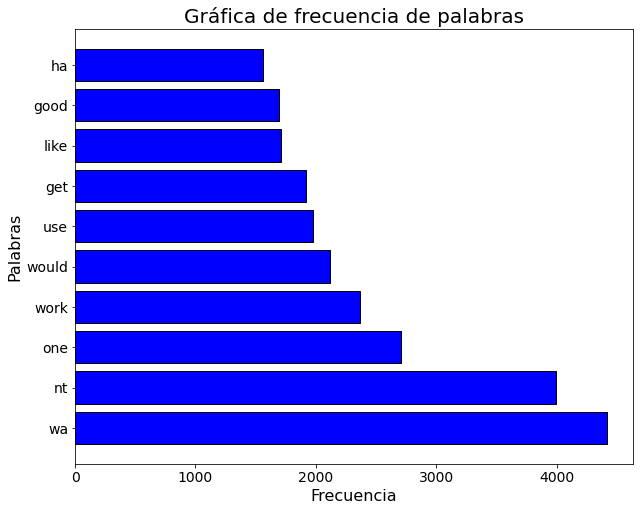

In [ ]:
freqdist = nltk.FreqDist([token for tokens in processed_df['processed_tokens'] for token in tokens])
# Obtener las 10 palabras más frecuentes y sus frecuencias
top_words = freqdist.most_common(10)
print('Lista de las palabras mas frecuentes:')
for word, freq in top_words:
    print(f"{word}: {freq}")

#llamamos a la función createFrecuencieWordsBar de la clase Graphics para generar gráfico
graphics.createFrecuencieWordsBar(top_words)

### Visualizamos el histograma del tamaño de los tokens preprocesados

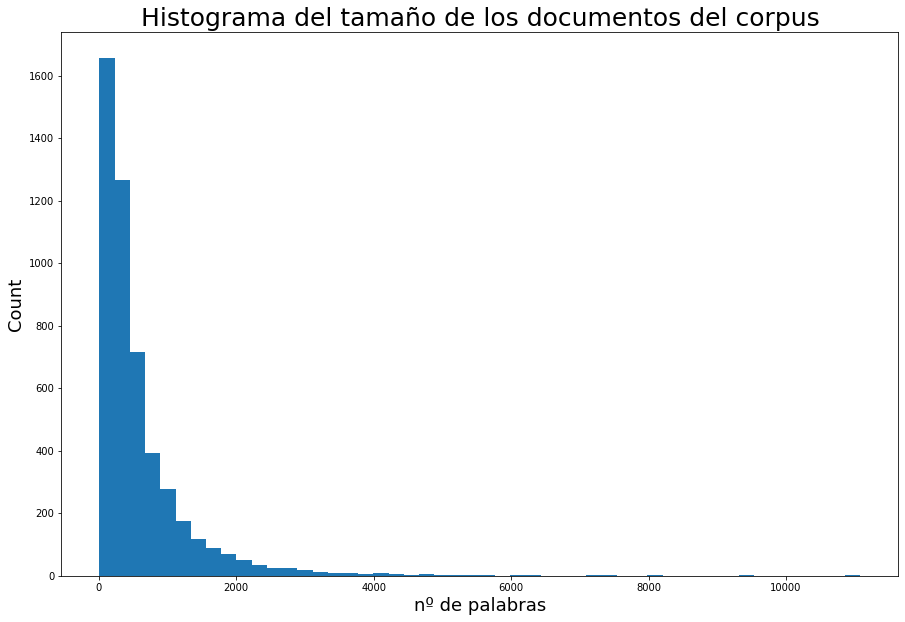

In [ ]:
# Análisis de longitud de texto de las reviews
processed_df['text_length_tokens'] = processed_df['processed_task'].apply(lambda x: len(x))
graphics.createHistogram(processed_df, 'text_length_tokens')

###Ahora vamos a visualizar la nube de palabras

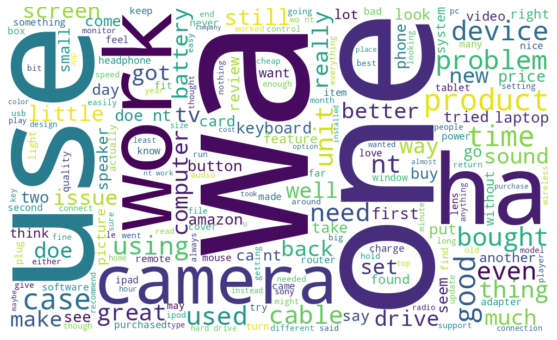

In [ ]:
text = " ".join(processed_df["processed_tokens"].apply(lambda tokens: " ".join(tokens)))
graphics.createWorldCloud(text)

##Realizamos el split de los datos

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    processed_df['processed_task'],
    processed_df['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

In [ ]:
#Realizamos el guardado del diccionario con los set de datos en la carpeta datasets
dic_training_sets = {
    'X_train':X_train,
    'X_test':X_test,
    'y_train':y_train,
    'y_test':y_test
}
with open(f'{path}dic_training_sets.pkl', 'wb') as f:
    pickle.dump(dic_training_sets, f)

In [ ]:
X_train.iloc[:10]

2245    surprise_RB many_JJ different_JJ gadget_NNS ne...
1870    little_JJ cable_NN reason_NN cost_NN 14_CD tru...
2584    work_NN great_JJ easy_JJ installation_NN bough...
1615    bought_JJ device_NN wanted_VBD connect_JJ pc_N...
506     connects_NNS nexus_RB 7_CD unreliable_JJ somet...
2673    long_JJ time_NN buying_VBG various_JJ size_NN ...
4811    dream_NN cutting_VBG cable_NN cord_NN gone_VBN...
1946    3_CD yr_JJ old_JJ girt_NN rejected_VBD using_V...
1222    wa_NN gift_NN ha_NN nt_NN used_VBN recipient_N...
1113    recently_RB got_VBD product_NN back_RB decembe...
Name: processed_task, dtype: object

In [ ]:
y_train.iloc[:10]

2245    0
1870    0
2584    0
1615    0
506     1
2673    0
4811    1
1946    1
1222    0
1113    0
Name: sentiment_label, dtype: int64

#Vamos a realizar el preprocesado para entrenar un modelo CNN
Creamos una clase que realiza el preprocesado 

In [10]:
class TextPreprocessorCNN:

    def __init__(self, df:pd.DataFrame,num_words:int = 1000):
      self.X_train, self.X_test, self.y_train, self.y_test = self.trainTestSplit(df)
      self.reviewMetrics()
      self.tokenizer_object = Tokenizer(num_words= num_words)

    def preprocess(self, maxlen: int):  
      #tokenizer
      sequences_train, sequences_test, vocab_size = self.tokenizer()    
      # Padding
      padded_sequences_train = self.paddingSequences(sequences_train, maxlen)
      padded_sequences_test = self.paddingSequences(sequences_test, maxlen)  
      # #word2vec
      w2v_model = self.generate_word2vec(sequences_train)
      #embeding
      embedding_layer = self.generate_embedding(word2vec_model=w2v_model, vocab_size= vocab_size)
      return padded_sequences_train,padded_sequences_test ,embedding_layer,self.y_train, self.y_test

    def trainTestSplit(self, df:pd.DataFrame, train_size: float=0.75, test_size: float=0.25, random_state:int =42, shuffle:bool =True):
      X_train, X_test, y_train, y_test = train_test_split(
      df['processed_tokens'],
      df['sentiment_label'],
      train_size=0.75,
      test_size=0.25,
      random_state=42,
      shuffle=True
       )
      return X_train, X_test, y_train, y_test
    def reviewMetrics(self):
      max_length = 0
      total_length = 0
      num_examples = len(self.X_train)

      for example in self.X_train:
          length = len(example)
          total_length += length
          if length > max_length:
              max_length = length
      mean_length = total_length / num_examples

      print('---------------------------------------')
      print(f'El tamaño máximo de review: {max_length}\n')
      print('---------------------------------------')
      print(f'La media de palabras por review: {mean_length}\n')

    def tokenizer(self):

      # Concatenar las columnas usando pd.concat()
      sequences = pd.concat([self.X_train, self.X_test],axis=0)

      # Verificar que la concatenación se realizó correctamente
      self.tokenizer_object.fit_on_texts(sequences)
      vocab_size = len(self.tokenizer_object.word_index) + 1
      sequences_train = self.tokenizer_object.texts_to_sequences(self.X_train)
      sequences_test = self.tokenizer_object.texts_to_sequences(self.X_test)
      return sequences_train, sequences_test, vocab_size

    def paddingSequences(self, sequences, maxlen: int):
      padded_sequences = pad_sequences(sequences, maxlen=maxlen)
      return padded_sequences

    def generate_word2vec(self, sequences_train):     
      sequences_train = [str(sequence) for sequence in sequences_train]
   
      documents = [sequence.split() for sequence in sequences_train]
      w2v_model =Word2Vec(
          size=300,
          window=5,
          min_count=2,
          workers=mp.cpu_count(),
      )
      w2v_model.build_vocab(documents)

      words = w2v_model.wv.vocab.keys()
      vocab_size = len(words)
      print(f"Vocab size: {vocab_size}")
      w2v_model.train(documents, total_examples=len(documents), epochs=2)

      return w2v_model

    def generate_embedding(self, word2vec_model, vocab_size):
      embedding_matrix = np.zeros((vocab_size, 300))
      for word, i in self.tokenizer_object.word_index.items():
          if word in word2vec_model.wv:
              embedding_matrix[i] = word2vec_model.wv[word]
      return Embedding(
          vocab_size,
          300,
          weights=[embedding_matrix],
          input_length=1200, 
          trainable=False,
    ) 

In [11]:
cnn_preproces = TextPreprocessorCNN(processed_df)
padded_sequences_train,padded_sequences_test ,embedding_layer,y_train, y_test = cnn_preproces.preprocess(maxlen = 1200)

---------------------------------------
El tamaño máximo de review: 989

---------------------------------------
La media de palabras por review: 62.92313851080865

Vocab size: 1918


In [12]:
dic_cnn_sets = {
    'padded_sequences_train':padded_sequences_train,
    'padded_sequences_test':padded_sequences_test,
    'y_train':y_train,
    'y_test':y_test,
    'embedding_layer':embedding_layer
    }
with open(f'{path}dic_cnn_sets.pkl', 'wb') as f:
    pickle.dump(dic_cnn_sets, f)